---
title: "Baby's First Language Model"
author: "Matt Allen"
date: "2024-05-04"
categories: [ai, language model]
image: "MLP.png"

format:
    html:
        code-fold: true
jupyter: python
---

In [1]:
import os
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt # from making figures
%matplotlib inline
from fastbook import *

generator_seed = 37

## Introduction

This piece is an introduction to language models by way of the paper [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). The paper develops a Multilayer Perceptron (MLP) with learned distributed feature vectors for each word. Nowadays the distributed feature vectors are called embeddings. Embeddings are a solution to the curse of dimensionality i.e. the model will be able to group similar concepts in a vector space to generalize better. As the paper states, it fights the curse of dimensionality with its own weapons. The training sentences inform the model about a combinatorial number of other sentences. In the context of this post, the training sentences are baby names from the Social Security Administration.

We will start with a bigram model, which is a special case of [n-gram language models](https://en.wikipedia.org/wiki/Word_n-gram_language_model). An n-gram model uses n-1 tokens to predict the next token. It is a Statistical language model that uses counts of the previous character combinations to predict the next token. We will compare this to a simple Neural Network with a single linear layer and then go onto develop an MLP with embeddings. We will be able to use these models as Generative AI to create new name like words.

The MLP architecture was replaced by Recurrent Neural Networks which were replaced by LSTMs which were replaced by Transformers. However, the language modeling framework developed in this paper is still used today. Furthermore, MLP layers are alternated between attention layers in the Transformer architecture of modern LLMs. Also, the fundamentals of tokenization, embeddings, hyperparameters and training loops remain. MLPs are a good place to start in language modeling, because they are easier to understand than transformers and are still trainable with smaller compute.

## Data

The data are first names registered with the Social Security Administration (SSA) from the year of birth 1880 to 2022. Each row contains a name, gender and number of SSA registrations with that name. Here is an example row:

Stephanie,F,22775

A zip file was downloaded that contains data across years 1880 to 2022. Each file contains one year. All the  files across those years were read and the name was pulled out of the row and changed to be all lowercase without distinguishing between gender, year or popularity. Here is an example row after data wrangling from the file yob1991.txt to be used in the models:

stephanie

All the unique names across all the years were combined into a single file called names_1880_To_2022.txt, so that the data wrangling step just needs to be done once and then the data can be read from the file.

In [4]:
# this step does the data wrangling.
# get the data into a reusable format
# use the output file of this step to build examples for the model

# set wrangle_data to True if you haven't created names_1880_To_2022.txt yet.
# the data was downloaded and unzip from https://www.ssa.gov/OACT/babynames/names.zip
# the names folder is at the same level in the file system as this notebook.
wrangle_data = False

# https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
def get_filepaths(directory):
    """
    This function will generate the file names in a directory 
    tree by walking the tree either top-down or bottom-up. For each 
    directory in the tree rooted at directory top (including top itself), 
    it yields a 3-tuple (dirpath, dirnames, filenames).
    """
    file_paths = []  # List which will store all of the full filepaths.

    # Walk the tree.
    for root, directories, files in os.walk(directory):
        for filename in files:
            # Join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)  # Add it to the list.

    return file_paths  # Self-explanatory.


if(wrangle_data):
    # Run the above function and store its results in a variable. 
    # Get all the files paths in the names folder.  
    full_file_paths = get_filepaths("names")
    # number of files
    number_of_files = len(full_file_paths)

    # put all the names into an array. make them all lowercase
    all_names = []

    for f in full_file_paths:
        if f.endswith(".txt"):
            names_split = open(f).read().splitlines()
            all_names.extend([line.split(',')[0].lower() for line in names_split])

    # collect some stats on the data
    number_of_names = len(all_names)
    unique_names = list(set(all_names))
    number_of_unique_names = len(unique_names)

    # save the unique names to a file
    with open('names_1880_To_2022.txt', 'w') as f:
        f.write('\n'.join(unique_names))

Let's read in and look at the data. Below you can see that the shortest names are two letters and the longest are 15.

In [12]:
ssa_names = open('names_1880_To_2022.txt').read().splitlines()

total_number_names = len(ssa_names)
print("total number of names:", total_number_names)

min_len_word = min(len(w) for w in ssa_names)
max_len_word = max(len(w) for w in ssa_names)
print("min length word:", min_len_word, "max length word:", max_len_word)

shortest_names = [w for w in ssa_names if len(w) <= min_len_word]
longest_names = [w for w in ssa_names if len(w) >= max_len_word]
print("shortest_names:", shortest_names)
print("longest_names:", longest_names)

#random.seed(generator_seed) # uncomment if you want the names to always be the same.
print("random sample of 5 names: ", random.choices(ssa_names, k=5))

total number of names: 102449
min length word: 2 max length word: 15
shortest_names: ['ii', 'ja', 'vi', 'od', 'kd', 'ax', 'jd', 'jp', 'st', 'sa', 'rc', 'jt', 'xi', 'ju', 'zy', 'mi', 'kj', 'cj', 'ho', 'se', 'io', 'ge', 'eh', 'jw', 'un', 'kc', 'no', 'an', 'mr', 'va', 'oz', 'du', 'ji', 'ah', 'tr', 'mc', 'si', 'zi', 'ld', 'go', 'pj', 'la', 'qi', 'jm', 'or', 'bj', 'sy', 'lu', 'ao', 'zo', 'su', 'ed', 'xu', 'za', 'ra', 'bb', 'na', 'ry', 'ki', 'pa', 'gy', 'md', 'vu', 'fu', 'ti', 'lj', 'jo', 'ad', 'ej', 'di', 'jl', 'my', 'ku', 'mu', 'lc', 'vy', 'te', 'ar', 'aj', 'ze', 'rb', 'ly', 'jc', 'el', 'so', 'ya', 'ma', 'gi', 'ia', 'yu', 'po', 'li', 'ac', 'lb', 'sj', 'tu', 'ke', 'fe', 'ro', 'kt', 'dj', 'al', 'eb', 'wa', 'mj', 'ab', 'oh', 'rj', 'tc', 'je', 'hy', 'lg', 'yi', 'om', 'yy', 'oc', 'ty', 'me', 'ko', 'av', 'ny', 'ng', 'yo', 'ai', 'jb', 'ka', 'jj', 'ru', 'ea', 'ni', 'ky', 'da', 'rd', 'de', 'le', 'bo', 'do', 'ta', 'rl', 'jr', 'ye', 'in', 'mo', 'ok', 'wc', 'hu', 'wm', 'ha', 'bg', 'ba', 'be', 'lo', 'c

After reading the data from the file, we tokenize the data. Tokenization is a subject in itself. We will create a very simple tokenizer. The tokenizer creates a vocabulary of 26 lower case letters of the alphabet plus a '.'. The '.' is used as a special character used to mark the beginning and end of names.

We build the tokenizer vocabulary by concatenating all the names together with no spaces and then create an ordered list of unique characters. This ends up covering all 26 lowercase letters in the English alphabet. We add the '.' character to this list.

We create two mappings. One that encodes the characters to numbers and one that decodes numbers to characters. We need to convert the words to numbers, because that is the language of computers. We convert numbers back to characters, so that English speaking humans can understand it.

In [17]:
# tokenizer: the tokens are '.' + lowercase alphabet
tokens = ['.'] + sorted(list(set((''.join(ssa_names)))))
print("tokens:", tokens)

# token to int converter
stoi = {s:i for i,s in enumerate(tokens)} # string to int
print("stoi:", stoi)
# int to token converter
itos = {i:s for s,i in stoi.items()} # int to string
print("itos:", itos)

tokens: ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi: {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos: {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


Finally, we create a function that will build the inputs and outputs that we will feed to the models. The inputs and outputs are created with names that have been shuffled and split into Training, Development and Test sets. The training set is used to train our model by updating its weights. We use the development/validation set to tune hyperparameters. Finally, we use the Test set sparingly. Ideally it is used only once. The performance of the model is based on the Test set. That is the number we would report in our paper and show off to our friends and family.

The concept is that we want the model to perform well on unseen data. If we were to use Training set metrics to report the performance of our model, our model could simply memorize the training data to get the possible performance, but it would not do well on new data. Everytime we use a set of data to calculate model performance, the model is learning something from it and it starts to fit to it, but again we want to evaluate our models on data that it has not seen.

We could wind up in the scenario that the Test Set performance is not good. Unfortunately, that means we may have to start over. It is not a good situation, but it is better to know.

The function also takes a block_size value. This parameter determines the size of the context. That is the number of characters of input we use to predict the next character. In a Bigram model for example, the block_size is 1.

Each name training data contains several examples. For example with a block_size of 3, the name matt contains five examples and the name kathy contains six examples:

In [40]:
# block size is the context length
def build_dataset(words, block_size = 1, verbose = False): 
    X, Y = [], []
    
    ndex = 0
    num_examples_to_print = 2

    for w in words:
        if verbose and ndex < num_examples_to_print:
            print(w)
            print("input ---> output")
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            if verbose and ndex < num_examples_to_print:
                # pretty print first three names
                print(''.join(itos[i] for i in context), '--->', itos[ix])
                
            context = context[1:] + [ix] # crop and append

        ndex = ndex + 1

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [41]:
build_dataset(['matt', 'kathy'], block_size = 3, verbose = True)

matt
input ---> output
... ---> m
..m ---> a
.ma ---> t
mat ---> t
att ---> .
kathy
input ---> output
... ---> k
..k ---> a
.ka ---> t
kat ---> h
ath ---> y
thy ---> .


(tensor([[ 0,  0,  0],
         [ 0,  0, 13],
         [ 0, 13,  1],
         [13,  1, 20],
         [ 1, 20, 20],
         [ 0,  0,  0],
         [ 0,  0, 11],
         [ 0, 11,  1],
         [11,  1, 20],
         [ 1, 20,  8],
         [20,  8, 25]]),
 tensor([13,  1, 20, 20,  0, 11,  1, 20,  8, 25,  0]))

## Bigram model (Special case of N-Gram)

The bigram model uses one character of context to predict the next character. The simplest construction of this model is to count frequencies of two characters occurring one after the other. We can use these frequencies to create an n-gram model, which is a probability distribution to predict the next character. It is the probability distribution of the next character conditioned on previous characters. In the case of a Bigram, there is only one previous character to condition on.

To build our Bigram model, we create a table of counts of two letter combinations and count all those combinations in the data. Let's look at the data through a visual of the counts for every two character combination. The underlying tensor will be used to build the bigram model.

First we split the data into training, development/validation and test sets and then use the build_dataset function created earlier to get the inputs and outputs. Our dataset split is 80% training, 10% development/validation and 10% test.

In [46]:
# shuffle the words and then get the training splits
random.shuffle(ssa_names) # mix the words up
n1 = int(0.8*len(ssa_names)) # cut off point for training set
n2 = int(0.9*len(ssa_names)) # cut off for dev set

# build bigram dataset. note second dimension of x is 1. this is the context length (block_size)
words_tr = ssa_names[:n1]
Xtr, Ytr = build_dataset(words_tr, verbose=True) # training set used to update model parameters
print("Xtr shape:", Xtr.shape, "Ytr shape: ", Ytr.shape)

words_dev = ssa_names[n1:n2]
Xdev, Ydev = build_dataset(words_dev, verbose=False) # development or validation set used to tune hyper parameters like embedding size or hidden layer size
print("Xdev shape:", Xdev.shape, "Ydev shape: ", Ydev.shape)

words_te = ssa_names[n2:]
Xte, Yte = build_dataset(words_te, verbose=False) # test set used once or sparingly. report the performance of the model based on this set.
print("Xte shape:", Xte.shape, "Yte shape: ", Yte.shape)

vanisha
input ---> output
. ---> v
v ---> a
a ---> n
n ---> i
i ---> s
s ---> h
h ---> a
a ---> .
sanijah
input ---> output
. ---> s
s ---> a
a ---> n
n ---> i
i ---> j
j ---> a
a ---> h
h ---> .
Xtr shape: torch.Size([616865, 1]) Ytr shape:  torch.Size([616865])
Xdev shape: torch.Size([76881, 1]) Ydev shape:  torch.Size([76881])
Xte shape: torch.Size([77283, 1]) Yte shape:  torch.Size([77283])


Next we create a function that will take a training data split and generate a table of counts. For the bigram model the table dimensions are 27 X 27. The 27 possible input characters label the rows and the 27 possible output characters label the columns. The function initializes a 27 X 27 table with all zeros and then adds one to a cell everytime it finds a corresponding two letter permutation for a particular cell.

We then use this function to initialize our training set matrix.

In [48]:
# takes X and Y from Build Dataset and Creates a Counts Tensor
# counts_shape is the shape of the tensor for counts
def create_counts(X, Y, counts_shape = (27,27)):
    N = torch.zeros(counts_shape, dtype=torch.int32) # initialize tensor to 0
    for ndx in zip(X, Y):
        ndx = ndx[0].tolist() + [ndx[1].item()]
        N[tuple(ndx)] += 1

    return N

N = create_counts(Xtr, Ytr)

Now that we have our counts matrix. Let's visualize it.

Each row in the table is a fixed first letter followed by each of the letters in our vocabulary. The cell is the count of the number of times a two letter permutation occurred in the training data. For example, 'c' was followed by an 'o' 1027 times in the training data.

Higher counts make the cell more blue.

Notice that some two letter permutations never occurred in the training data like "kg" or "jf" for example.

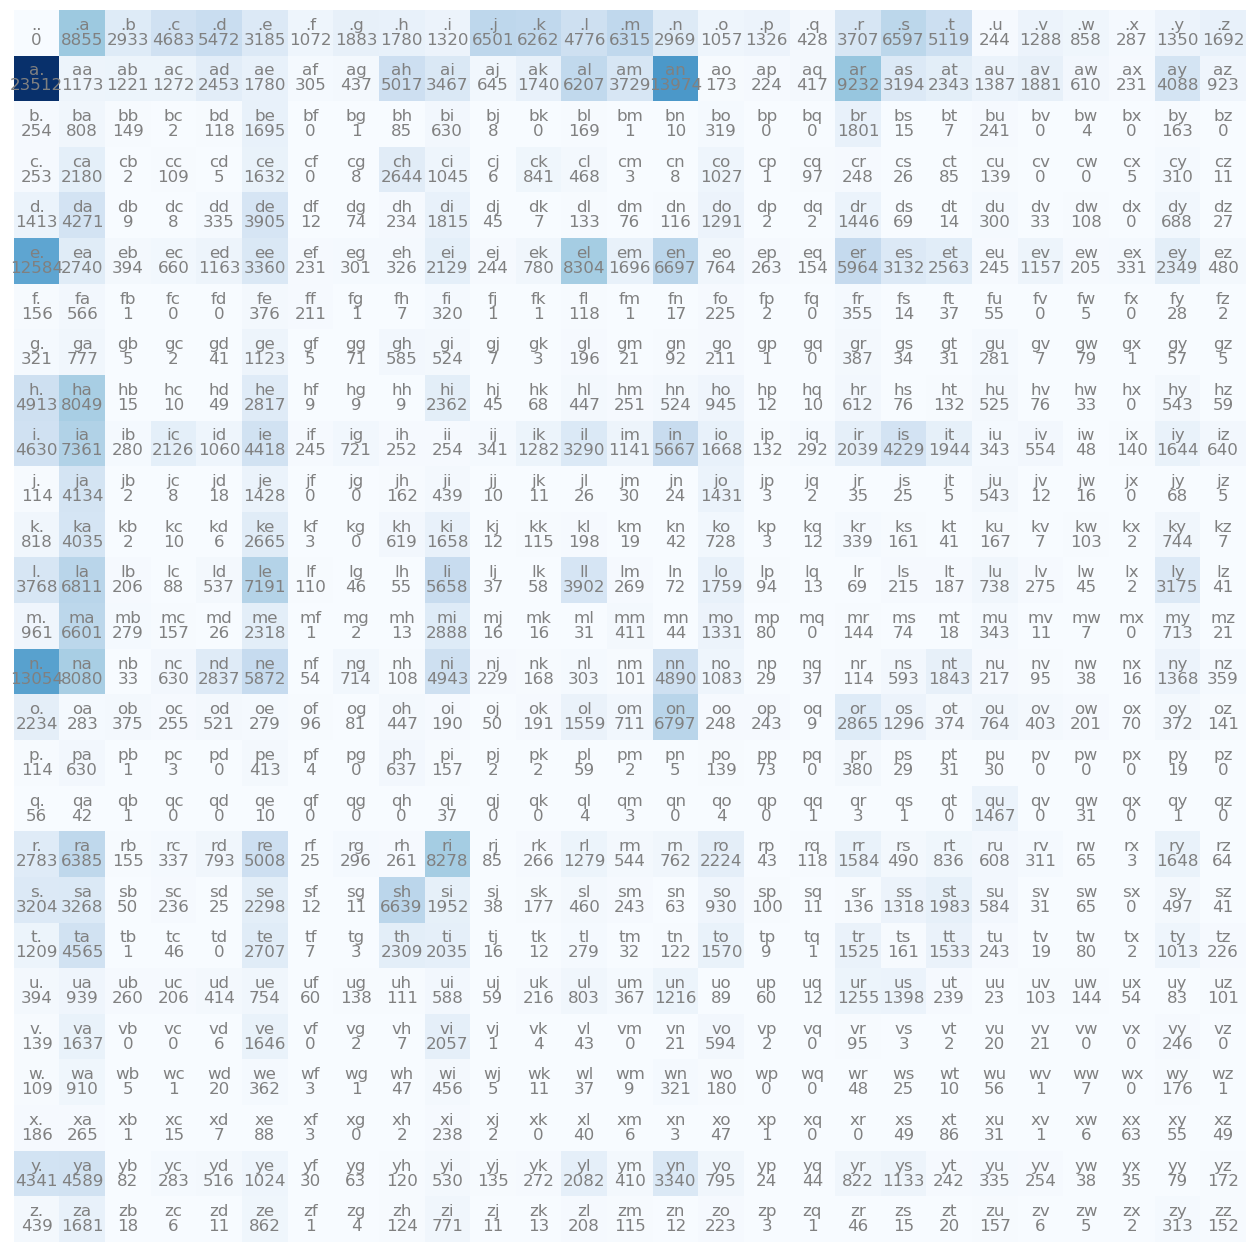

In [49]:
# visuzalize counts
# create image of N to visualize the counts of two character combinations
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j] # every 2 character combination where order matters
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")
plt.axis('off');

Now we normalize the counts to create a [Probability Distribution](https://en.wikipedia.org/wiki/Probability_distribution) i.e. divide all elements in the row by the sum of the row. Every value in each row is now between 0 and 1 and the values in each row summed together add to 1. Specifically each row is a [Multimonial Probability Distribution](https://en.wikipedia.org/wiki/Multinomial_distribution). This will be used to sample from each row to predict the next character in a name. 

Since some of the values are 0, we add 1 to all the cells to give everything at least some small probability of being chosen. It turns out adding a constant to each row makes the distribution smoother. In the extreme case as the constant goes to inifinity the distribution gets flat and every value in the row has equal probability. In our case for large values of the smoothing parameter, all the probabilities would be close to 1/27. You can try out different values of the smoothing parameter. You can think of it as Temperature in LLMs. As the smoothing parameter gets larger, it raises the probability of weird (unaligned) output.

We can now use this table of normalized rows to generate names. Below are names generated from the counts model.

In [50]:
# Add smoothing
# try various values
smoother =  1 #, 100, 50, 5, 110000000000000, 11

# Convert rows to 27 multinomial distributions
# Add 1 to N for smoothing. Prevents character combinations with 0 probability.
# We will be using log later, so also prevents log(0) = inf
# Also as if make constant add large the dist approaches uniform.
P = (N+smoother).float() # convert int tensor to floats for prob dist
P/= P.sum(1, keepdim=True) # normalize rows in place

# create a function to sample from the model
def bigram_generate_names(num_names, is_uniform = False):
    g = torch.Generator().manual_seed(generator_seed) # random seed for reproducibility

    p = torch.ones(27) / 27.0 # uniform case. every character has 1/27 chance of being chosen.

    for i in range(num_names):
        out = []
        ix = 0 # first letter comes from the first row
        while True:
            if(not is_uniform):
                p = P[ix] # use distribution based on the count date versus flat uniform dist

            # sample from a multinomial distribution. think generalization of coin flipping.
            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            out.append(itos[ix])
            if(ix == 0): # went to special "." character which denotes end of name
                break
        print(''.join(out))

bigram_generate_names(10)

rvinn.
ash.
ylishonn.
mexawus.
zaredioyneluweyshamicke.
jan.
ven.
diays.
relyarrernirlanglera.
jedondsttaffoswe.


This doesn't look good. Well it depends on if you want a creative name or not. We would say the model is unaligned in Language Modeling parlance. The words are sort of name like, but are unusual. The bigram model just isn't that good, but what if we compare it to every letter having equal probability of being chosen next. This is shown below. This looks worse than the bigram model. While our bigram model is not great, we are doing better than a baseline of complete randomness.

You can also achieve a similar effect by making the smoothing constant large.

In [51]:
bigram_generate_names(10, is_uniform = True)

rqpnnkasxcylcjrhjbqqpxowjzyznfkdsxfrrkuwtyqmqfzvpv.
jrirvmac.
gmyxjrgjycrrpxniwlargyerapxgdxedsntaffqxwfbsbkyczuqrpslnmzqymlwntekcauujpfwqpllcagsglpevrlt.
.
mplif.
mbo.
ezsumg.
pekjdlzyuamzdmsyv.
lnwfvlwfnklwrrr.
yvmqnpqbwacvvotgzy.


We can observe the sample and see it does not look good, but how do we quantify if we are doing better or not. How do we evaluate the quality of the model? We need a measure of that.

We will use the average negative log likelihood. For this measure, lower numbers mean a better performing model. A function to calculate this measure for the bigram model is below.

It will take the test set of words and the probabilities derived from the training set and compute a number that represents the loss. This is how we will evaluate the quality of the model.

We find letter combinations in the test set and get the probability based on the table built from our training data. We take the log of that probability and add it to a running total. This is the total log likelihood. We also keep track of the number of letter permutations we checked. The sum of all the log likelihoods divided by the total number two letter permutations is the average log likelihood. To get the negative log likelihood, we just multiply the average log likelihood by -1.

Average Negative Log Likelihood is the same thing as [Cross Entropy](https://en.wikipedia.org/wiki/Cross-entropy). See the Estimation section in the Cross Entropy Wikipedia article. Cross Entropy is a common term modern language modeling.

The loss of our bigram models is

In [52]:
# how to evaluate the quality of the model? average negative log likelihood, lower is better

# GOAL: maximize likelihood of the data w.r.t. mode parameters (statistical model)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html   
def likelihood_calc(words, verbose = False, is_uniform = False):
    log_likelihood = 0
    n = 0

    for w in words:
    #for w in ["matt"]: # can evaluate probability for any word
        chs = ['.'] + list(w) + ['.'] # hallucinate special start and end token to know where word begins an ends
        for ch1, ch2 in zip(chs, chs[1:]): # cute way to get tuples of consecutive chars in word
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            prob = P[ix1, ix2] # prob that the model assigns to the bigram
            if(is_uniform):
                prob = torch.tensor(1.0/len(stoi))

            logprob = torch.log(prob)
            log_likelihood += logprob
            n += 1

            if(verbose):
                print(f'{ch1}{ch2}: prob={prob: .4f} logprob={logprob: .4f}')

    #print(f'{log_likelihood=}') # range is 0 to neg inf
    nll = -log_likelihood # negative log likelihood
    #print(f'{nll=}')
    print(f'average negative log likelihood loss={nll/n}') # average log likelihood

# evaluate loss on test set
likelihood_calc(words_te, verbose = False, is_uniform = False)

average negative log likelihood loss=2.458792209625244


Below is the loss where the probability of every next character is 1 / 27 i.e. equally likely. Remember our vocabulary is 26 letters of the alphabet plus the '.' character to make 27 in total.

In [53]:
# compute the loss on the Test set
likelihood_calc(words_te, verbose = False, is_uniform = True)

average negative log likelihood loss=3.2966856956481934


The Bigram model that uses the data is an improvement on the model that assumes every character is equally likely. The bigram model's loss is 2.45, which is less than the loss of 3.29 where the data is ignored.